In [128]:
# ------------All libraries use din this notebook-------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from factor_analyzer import FactorAnalyzer
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from scipy.stats import f_oneway
import scipy.stats as stats
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve,auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [129]:
#-------------------------- Reading Data from my Local repository----------------------------
""" -------------------Datatset Details------------------------------------
    Dataset Name:Adult
    URL: https://archive.ics.uci.edu/dataset/2/adult
    Domain: Social Science
    Instances: 48842
    Features: 14
    Feature Type: Categorical, Integer
    Target Variable: income

"""
def Data_Load():
    columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation','relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    df = pd.read_csv('../Datasets/adult.data',names=columns, sep=',\s', engine='python')
    return df

In [130]:
def Data_Cleaning(df):
    # Fill NaN values in numerical columns with mean
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

    # Fill NaN values in categorical columns with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

    return df

In [131]:
def Data_Transformation(df):
   # Fill missing values with mean for numerical columns and mode for categorical columns
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].mean())

    # Convert income to binary labels
    df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

    # One-hot encode categorical columns
    df_encoded = pd.get_dummies(df, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

    return df_encoded

In [132]:
# ---------------------------------------- EDA Explaination----------------------------------------------------
"""1- Descriptive Statistics: It provide a summary of the main characteristics of a dataset. For Example in given dataset there are some features that i ahve to analyze:
        For example for age variable, Mean shows the average income of the person.Standard Deviation shows spread of ages around the mean. Similarly,Min and Max shows incomes.
Quartiles (Q1, Q2, Q3) divide the age in dataset into four equal parts. """

"""3-Covariance & Correlation Matrix: In results, positive covariance indicates that as one variable increases, the other variable also tends to increase, and vice versa. I also created correlation it mean correlation of 1 indicates a perfect positive linear relationship,-1 indicates a perfect negative linear relationship, and 0 indicates no linear relationship. I also make correlation Heatmap once we run fun ction we can see it and where we can see clearly the results of it and relationship between variables. """

"""4- I also draw histograms and box plots for variables. Histograms provide insights into the central tendency,variability, and shape of the distribution. It help identify patterns such as skewness etc.
 Box pLots provides five number summary where we can see plot and we can determine outliers etc
 For exmaple: A histogram of ages can help understand the distribution of incomes in given dataset, which is important for analyzing the demographics of cirrhosis patients.
 Similary using box plot, a boxplot of age can show the central tendency and spread of incomes in dataset, highlighting any potential outliers or unusual patterns in dataset."""
"""
    test accuracy is 75.82%. The classification report shows that the model has a precision of 82% for class 0 and 50% for class 1. The recall is 88% for class 0 and 38% for class 1. The F1-score is 85% for class 0 and 43% for class 1.
The ROC AUC for manual splitting is 0.6277, indicating moderate performance in distinguishing between the two classes. The cross-validation mean accuracy is 76.02%, which is consistent with the manual splitting test accuracy.
"""

'\n    test accuracy is 75.82%. The classification report shows that the model has a precision of 82% for class 0 and 50% for class 1. The recall is 88% for class 0 and 38% for class 1. The F1-score is 85% for class 0 and 43% for class 1.\nThe ROC AUC for manual splitting is 0.6277, indicating moderate performance in distinguishing between the two classes. The cross-validation mean accuracy is 76.02%, which is consistent with the manual splitting test accuracy.\n'

In [133]:
def EDA(df):
    # Summary statistics
    print("\nSummary statistics:")
    print(df.describe())

    # Check for missing values
    print("\nMissing values information:")
    print(df.isnull().sum())

    # Distribution of target variable
    plt.figure(figsize=(6, 4))
    sns.countplot(x='income', data=df)
    plt.title('Distribution of Income')
    plt.xlabel('Income (>50K vs <=50K)')
    plt.ylabel('Count')
    plt.show()

    # Numerical features histograms
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
    for feature in numerical_features:
        plt.figure(figsize=(8, 5))
        sns.histplot(df[feature], bins=20, kde=True)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.show()
    # Display pairplot for numerical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    sns.pairplot(df[numerical_cols])
    plt.title('Pairplot of Numerical Columns')
    plt.show() 
    
    # Box plots for numerical features
    for feature in numerical_features:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='income', y=feature, data=df)
        plt.title(f'Boxplot of {feature} by Income')
        plt.xlabel('Income (>50K vs <=50K)')
        plt.ylabel(feature)
        plt.show()

    # Categorical features bar plots
    categorical_features = df.select_dtypes(include=['object']).columns
    for feature in categorical_features:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=feature, hue='income', data=df)
        plt.title(f'Count of {feature} by Income')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Income', loc='upper right')
        plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

In [134]:
"""outliers identified as individual points that are located outside the whiskers of the plot. The whiskers represent the range within which most of the data points lie. Points that fall outside the whiskers are considered potential outliers"""
def Detecting_outliers_Anomalies(df):
    numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

    for column in numerical_columns:
        plt.figure(figsize=(8, 5))
        plt.boxplot(df[column], vert=False)
        plt.xlabel(column)
        plt.title(f'Boxplot of {column}')
        plt.show()

In [135]:
# we'll implement it once we done it in class
def Feature_Selection(df):
    return;

In [136]:
# we'll implement it once we done it in class
def Dimention_Reduction(df):
    return;

In [137]:
#------------------------------Splitting Data using Manual way-----------------------------
def manual_splitting(df, target_column, test_size=0.2, validation_size=0.2, random_state=42):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [138]:
#------------------------------Splitting Data using Cross Validation-----------------------------
def cross_validation(df, target_column, k=3, cv=5, random_state=42):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')

    return scores.mean()

In [139]:
# ----------I select Model KNeighborsClassifier and Trainign using both manual and CV ways and calculating accuracy
#-------------------------------Testing Manual splitting-------------------------------------
X_train, X_val, X_test, y_train, y_val, y_test = manual_splitting(Data_Transformation(Data_Load()), 'income')
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
test_accuracy_manual = accuracy_score(y_test, y_pred)

# ---------------------cross-validation-----------------------
cv_accuracy = cross_validation(Data_Transformation(Data_Load()), 'income')

In [140]:
# clalculationg classification metrics like accurary,precision,recall,roc
def classification_metrics(y_true, y_pred):
    # Convert labels to binary format
    label_binarizer = LabelBinarizer()
    y_true_binary = label_binarizer.fit_transform(y_true)
    y_pred_binary = label_binarizer.transform(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    roc_auc = roc_auc_score(y_true_binary, y_pred_binary, average='macro')

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true_binary.ravel(), y_pred_binary.ravel())
    roc_auc_curve = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_curve)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    return accuracy, report, roc_auc


In [141]:
"""--------------------Master function that execute all functions for KNN Classifier-------------------"""
def Master():
    # Calling function for loading the data
    df = Data_Load()
    print("Original Data Shape:", df.shape)
    # Calling function for data cleaning
    df_cleaned = Data_Cleaning(df)
    print("Cleaned Data Shape:", df_cleaned.shape)
     # Calling function for data transformation
    df_transformed=Data_Transformation(df_cleaned)
    print("Transformed Data Shape:", df_transformed.shape)
      # Calling function for Exploratiry Data Analysis (EDA)
    EDA(df_transformed)
    
     # Calling function for Outliers Detection
    Detecting_outliers_Anomalies(df_transformed)
    
    # Calling function for feature Selection
    Feature_Selection(df_transformed)
    
    # Calling function for Dimension Reduction
    Dimention_Reduction(df_transformed)
    
    # Split the data using manual splitting
    X_train_manual, X_val_manual, X_test_manual, y_train_manual, y_val_manual, y_test_manual = manual_splitting(df_transformed, 'income')

    # Train the model and get predictions for manual splitting
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_manual, y_train_manual)
    y_pred_manual = knn.predict(X_test_manual)

    # Get classification metrics for manual splitting
    accuracy_manual, report_manual, roc_auc_manual = classification_metrics(y_test_manual, y_pred_manual)

    # Get cross-validation accuracy
    cv_accuracy = cross_validation(df_transformed,'income')

    # Print the results for manual splitting
    print("Manual Splitting Test Accuracy:", accuracy_manual)
    print("Classification Report (Manual Splitting):")
    print(report_manual)
    print("ROC AUC (Manual Splitting):", roc_auc_manual)
    print()
    # Print the cross-validation accuracy
    print("Cross-Validation Mean Accuracy:", cv_accuracy)

Original Data Shape: (32561, 15)
Cleaned Data Shape: (32561, 15)
Transformed Data Shape: (32561, 109)

Summary statistics:
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week        income   workclass_?  workclass_Federal-gov  \
count    32561.000000  32561.000000  32561.000000           32561.000000   
mean

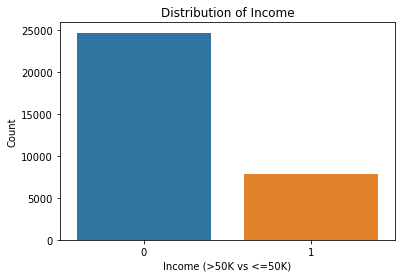

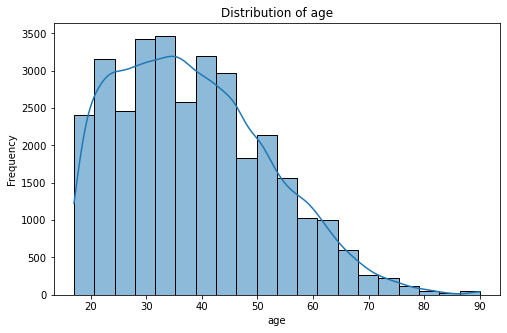

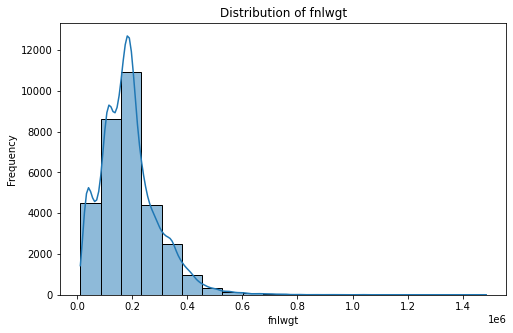

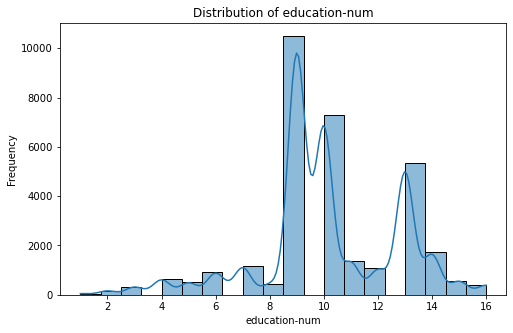

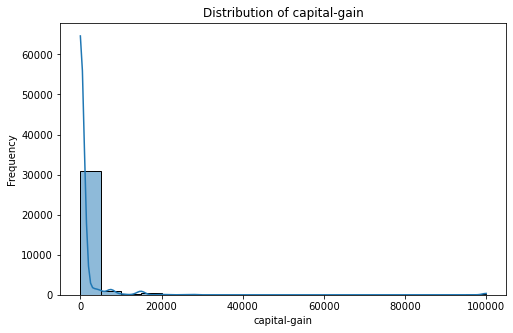

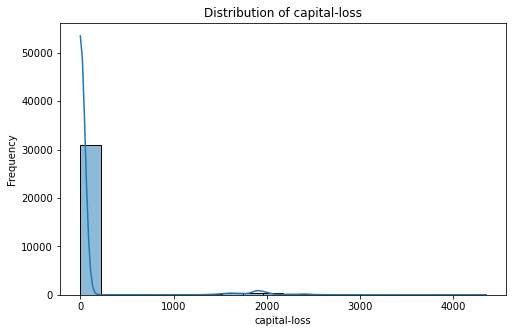

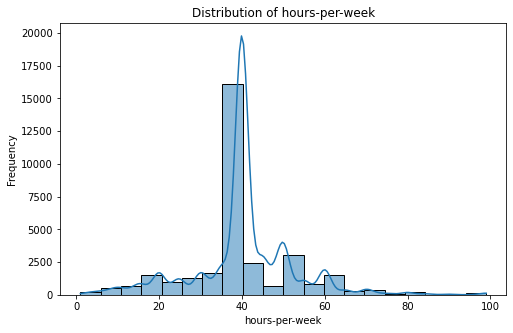

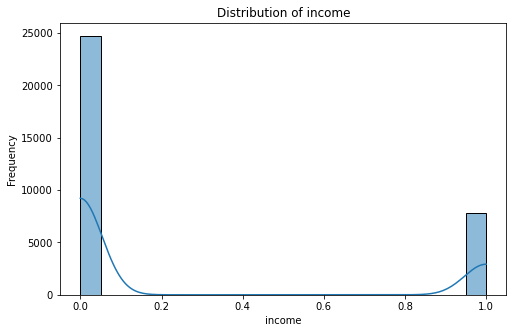

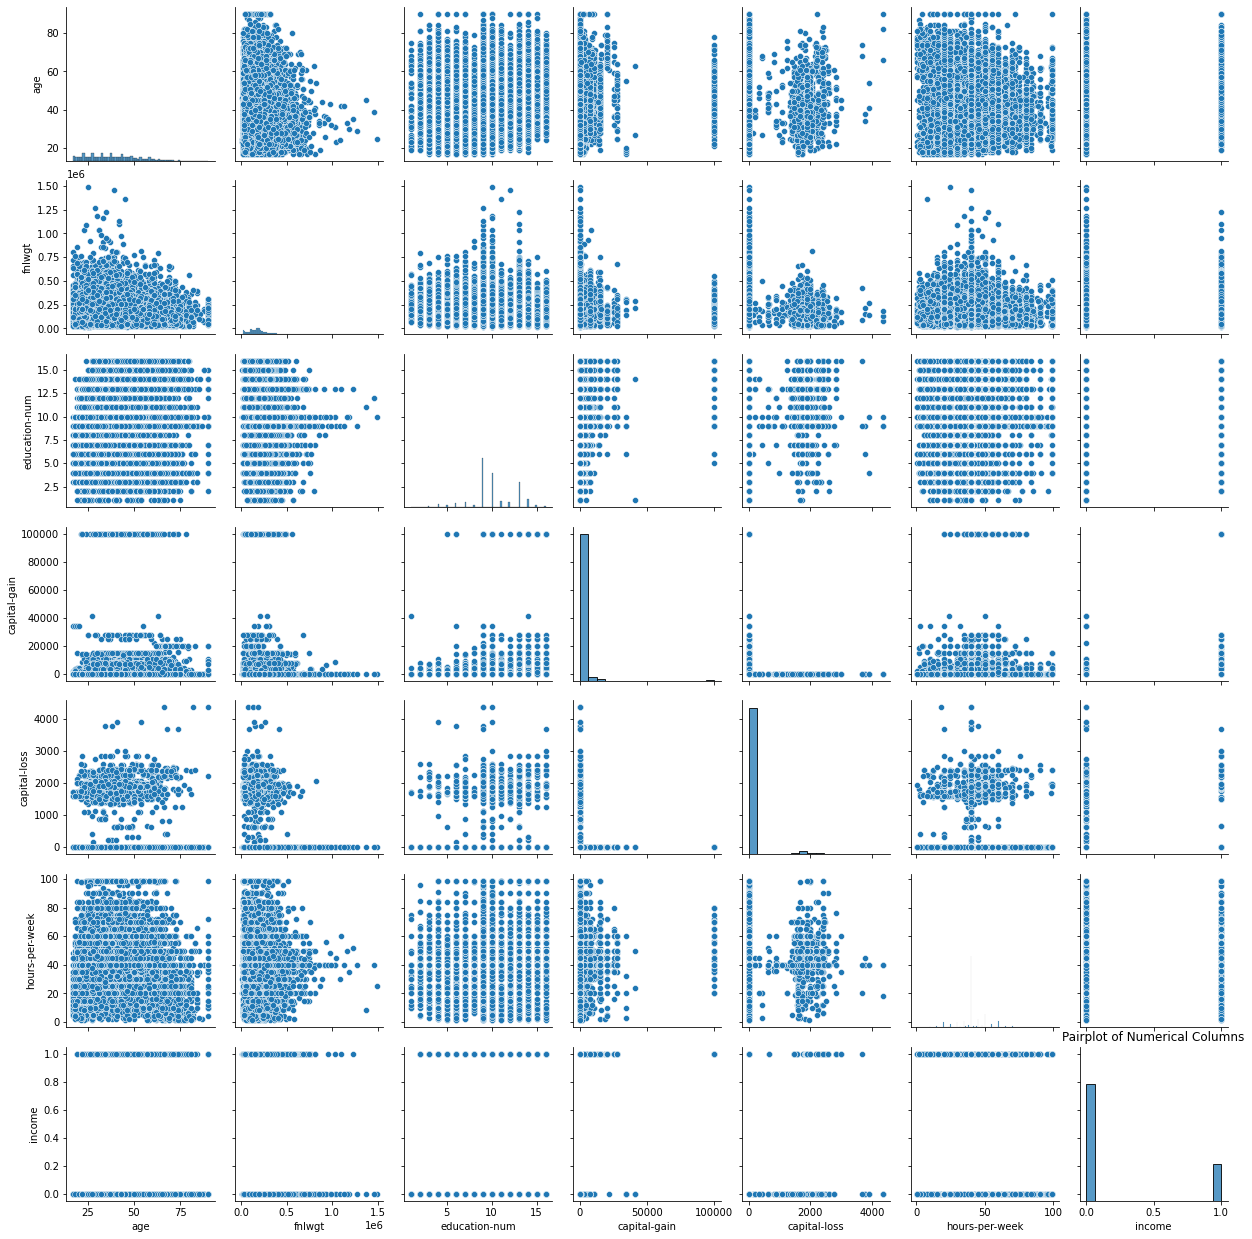

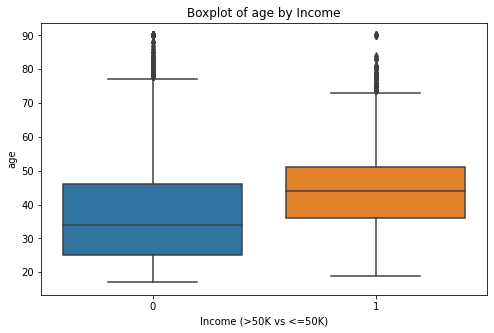

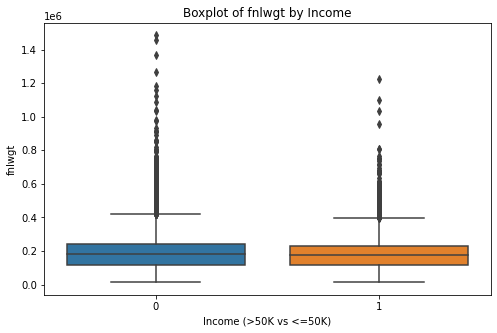

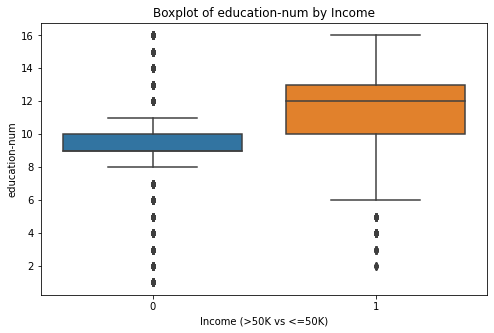

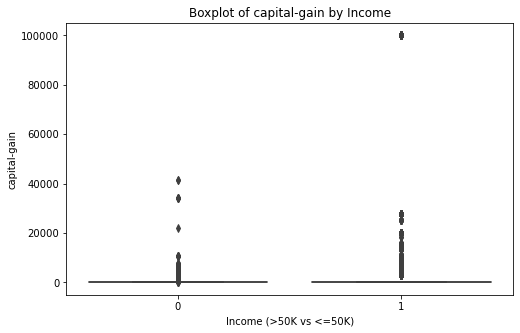

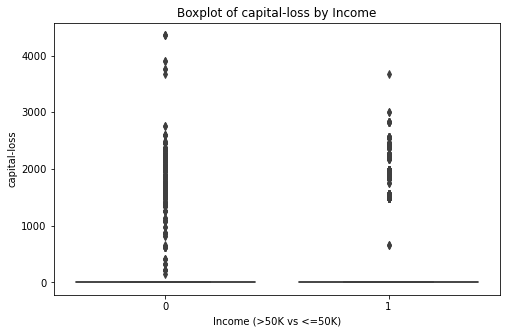

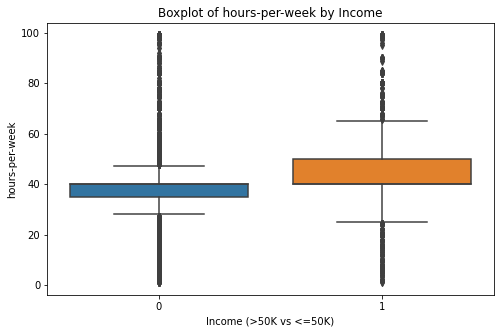

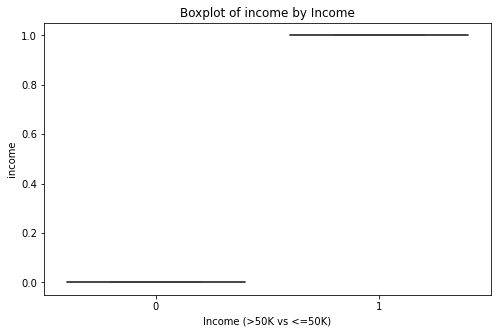

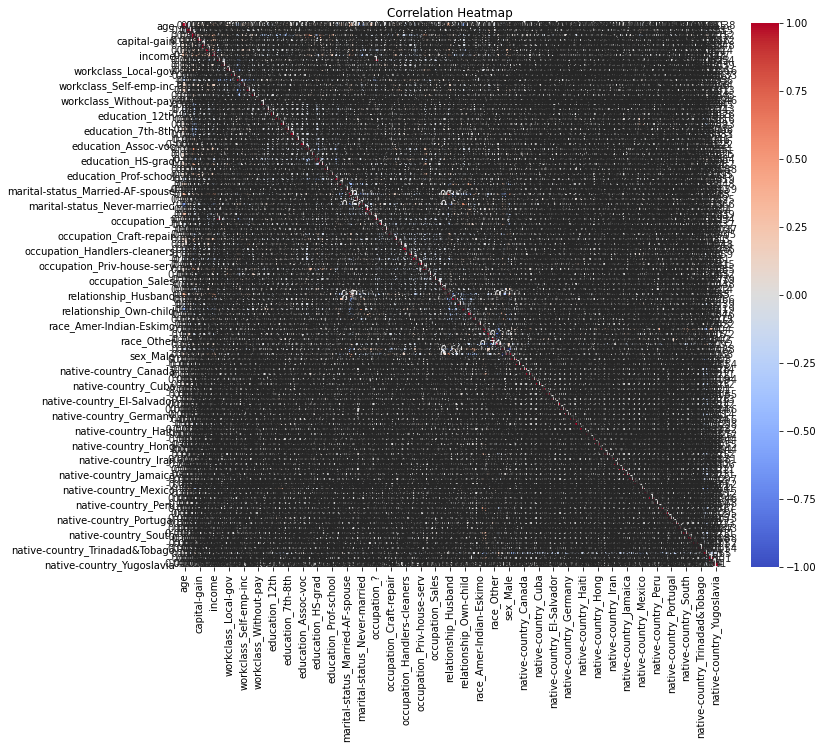

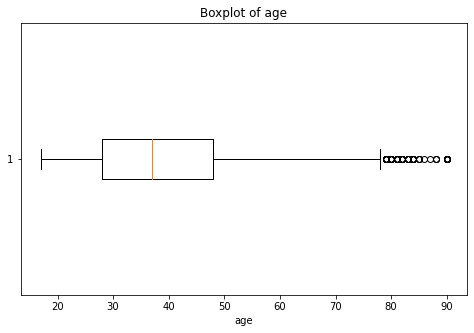

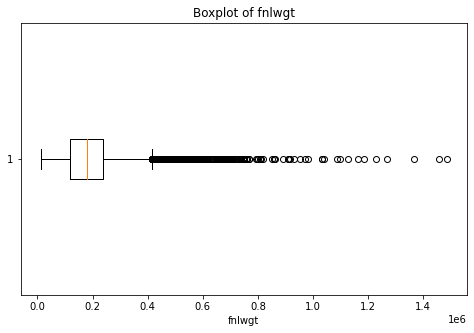

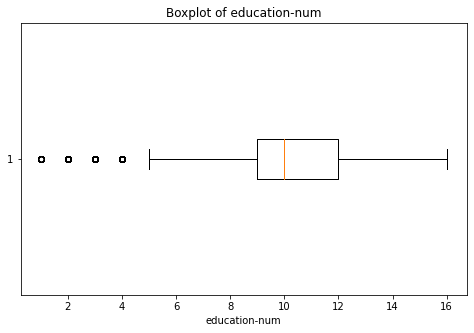

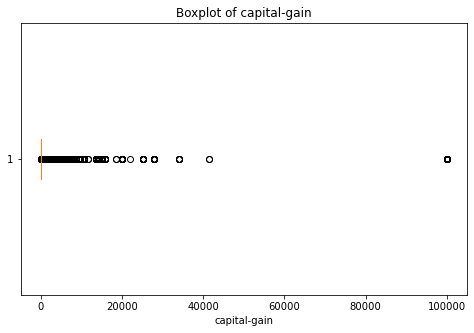

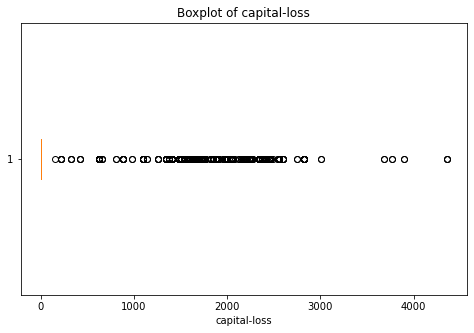

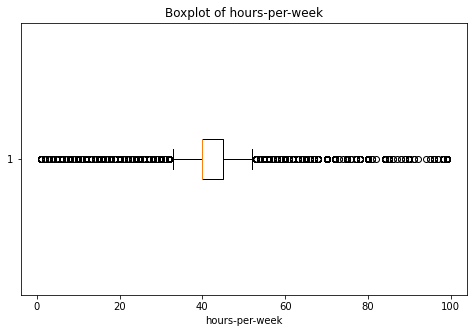

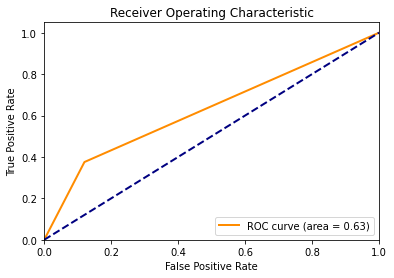

Manual Splitting Test Accuracy: 0.7581759557807461
Classification Report (Manual Splitting):
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      4942
           1       0.50      0.38      0.43      1571

    accuracy                           0.76      6513
   macro avg       0.66      0.63      0.64      6513
weighted avg       0.74      0.76      0.75      6513

ROC AUC (Manual Splitting): 0.6276813583720103

Cross-Validation Mean Accuracy: 0.760234619590907


In [142]:
# Master function that's controlling pipeline of fucntions
Master()